#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Régression logistique

 **Objectifs d'apprentissage :**
  * Reconstruire le prédicteur du prix médian des logements (sur la base des exercices précédents) sous la forme d'un modèle de classification binaire
  * Comparer l'efficacité de la régression logistique par rapport à la régression linéaire pour un problème de classification binaire

 Comme pour les exercices précédents, vous allez utiliser l'ensemble de données sur l'immobilier en Californie. Cette fois, cependant, vous allez créer un problème de classification binaire en prédisant la cherté d'un îlot urbain. Vous allez également rétablir les caractéristiques par défaut (pour l'instant).

 ## Présenter le problème en tant que classification binaire

La cible de cet ensemble de données est le prix médian des logements (`median_house_value`), qui est une caractéristique numérique (à valeur continue). Vous pouvez créer une étiquette booléenne en appliquant un seuil à cette valeur continue.

Compte tenu des caractéristiques qui décrivent un îlot urbain, vous souhaitez en prédire la cherté. Afin de préparer les cibles pour les données d'apprentissage et d'évaluation, vous allez définir un seuil de classification du 75e percentile pour le prix médian des logements (une valeur d'environ 265 000). Toutes les valeurs supérieures à ce seuil reçoivent l'étiquette `1`, tandis que les autres se voient affecter l'étiquette `0`.

 ## Configuration

Exécutez les cellules ci-dessous pour charger les données, et préparer les caractéristiques d'entrée et les cibles.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

 Vous remarquerez que le code ci-dessous diffère légèrement de celui des exercices précédents. Au lieu d'utiliser `median_house_value` comme cible, vous allez créer une cible binaire : `median_house_value_is_high`.

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # median_house_value is above a set threshold.
  output_targets["median_house_value_is_high"] = (
    california_housing_dataframe["median_house_value"] > 265000).astype(float)
  return output_targets

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2652.3,540.4,1432.1,502.0,3.9,2.0
std,2.1,2.0,12.6,2184.6,421.7,1126.7,384.9,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1463.0,298.0,791.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2127.0,435.0,1168.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3157.0,646.0,1729.0,604.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.7,2622.9,537.1,1423.4,499.3,3.9,2.0
std,2.1,2.0,12.6,2168.7,420.9,1197.1,383.7,1.9,1.0
min,32.5,-124.3,2.0,11.0,3.0,3.0,4.0,0.5,0.1
25%,33.9,-121.8,18.0,1456.8,294.0,786.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2128.5,431.0,1164.5,407.0,3.5,1.9
75%,37.7,-118.0,37.0,3141.2,654.0,1704.0,607.0,4.7,2.3
max,41.9,-114.3,52.0,30401.0,4957.0,35682.0,4769.0,15.0,41.3


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


 ## Comment fonctionne une régression linéaire ?
Pour comprendre l'efficacité de la régression logistique, commencez par entraîner un modèle naïf qui utilise la régression linéaire. Ce modèle utilisera des étiquettes avec des valeurs comprises dans l'ensemble `{0, 1}` et tentera de prédire une valeur continue aussi proche que possible de `0` ou `1`. Puisque vous souhaitez également interpréter la sortie comme une probabilité, l'idéal serait que la sortie se situe dans l'intervalle `(0, 1)`. Ensuite, un seuil de `0.5` sera appliqué pour déterminer l'étiquette.

Exécutez les cellules ci-dessous pour entraîner le modèle de régression linéaire à l'aide de la classe [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor).

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_linear_regressor_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 0.45
  period 01 : 0.45
  period 02 : 0.45
  period 03 : 0.44
  period 04 : 0.44
  period 05 : 0.44
  period 06 : 0.44
  period 07 : 0.44
  period 08 : 0.44
  period 09 : 0.44
Model training finished.


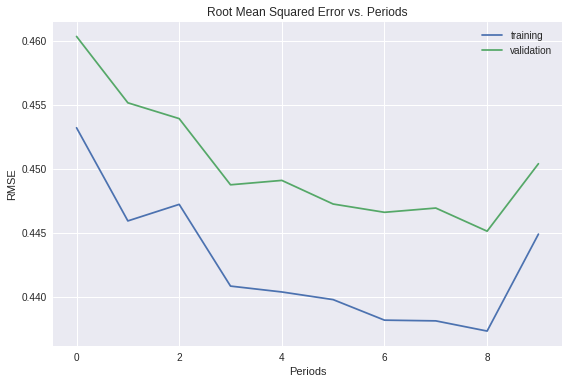

In [7]:
linear_regressor = train_linear_regressor_model(
    learning_rate=0.000001,
    steps=200,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## Tâche 1 : Est-il possible de calculer la perte logistique pour ces prédictions ?

**Examinez les prédictions et déterminez si elles peuvent être utilisées pour le calcul de la perte logistique.**

Le coût L2 utilisé par `LinearRegressor` ne s'avère pas très efficace pour pénaliser les classifications erronées lorsque la sortie est interprétée comme une probabilité. Ainsi, il devrait y avoir une énorme différence selon qu'un exemple négatif est classé comme positif avec une probabilité de 0,9 ou de 0,9999. Cependant, avec le coût L2, la différenciation n'est pas très nette.

En revanche, `LogLoss` pénalise beaucoup plus fortement ces "erreurs de confiance". Pour rappel, `LogLoss` se définit comme suit :

$$Log Loss = \sum_{(x,y)\in D} -y \cdot log(y_{pred}) - (1 - y) \cdot log(1 - y_{pred})$$


Avant toute chose, il est nécessaire d'obtenir les valeurs de prédiction. Pour ce faire, vous pouvez utiliser `LinearRegressor.predict`.

Compte tenu des prédictions et des cibles, est-il possible de calculer `LogLoss` ?

 ### Solution

Cliquez ci-dessous pour afficher la solution.

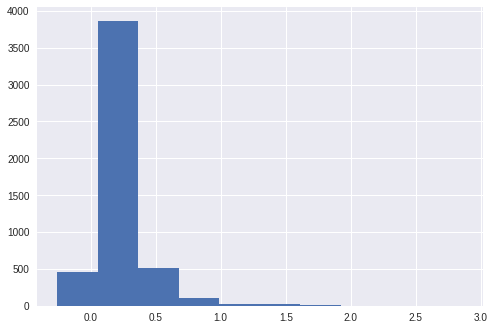

In [8]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

_ = plt.hist(validation_predictions)

 ## Tâche 2 : Entraîner un modèle de régression logistique et calculer la perte logistique sur l'ensemble de validation

Pour utiliser la régression logistique, remplacez simplement le modèle `LinearRegressor` par [LinearClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier). Exécutez le code ci-dessous.

**REMARQUE** : Lorsque vous exécutez `train()` et `predict()` sur un modèle `LinearClassifier`, vous pouvez accéder aux valeurs numériques réelles des probabilités prédites au moyen de la clé `"probabilities"` du dictionnaire renvoyé : `predictions["probabilities"]`, par exemple. La fonction [log_loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) de Sklearn est pratique pour calculer la perte logistique à l'aide de ces probabilités.


In [0]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_classifier =  tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

Training model...
LogLoss (on training data):
  period 00 : 0.60
  period 01 : 0.58
  period 02 : 0.60
  period 03 : 0.55
  period 04 : 0.54
  period 05 : 0.54
  period 06 : 0.53
  period 07 : 0.53
  period 08 : 0.53
  period 09 : 0.55
Model training finished.


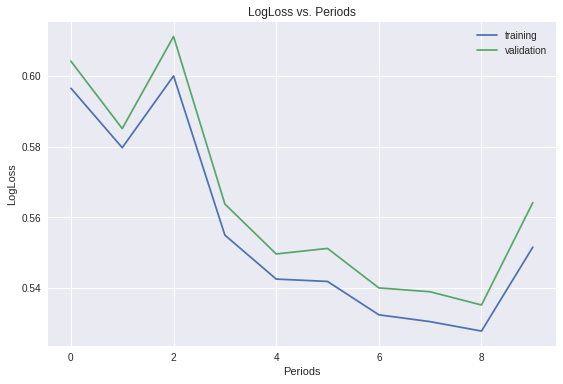

In [11]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### Solution

Cliquez ci-dessous pour afficher la solution.



In [0]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

In [0]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## Tâche 3 : Calculer la justesse et représenter graphiquement une courbe ROC pour l'ensemble de validation

La [justesse](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification) du modèle, la [courbe ROC] (https://fr.wikipedia.org/wiki/Courbe_ROC) et la zone sous la courbe ROC (AUC) figurent parmi les mesures utiles pour la classification. Nous allons les examiner.

`LinearClassifier.evaluate` calcule des mesures utiles telles que la justesse et l'AUC.

In [12]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

AUC on the validation set: 0.68
Accuracy on the validation set: 0.74


 Vous pouvez utiliser des probabilités de classe, telles que celles calculées par `LinearClassifier.predict`
et la fonction [roc_curve](http://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) de Sklearn, pour
obtenir les taux de vrais positifs et de vrais négatifs nécessaires pour la représentation graphique d'une courbe ROC.

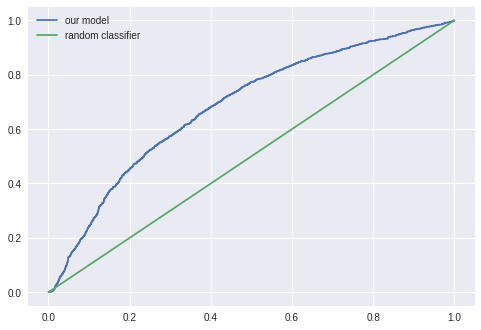

In [13]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

 **Voyons maintenant s'il est possible d'optimiser les paramètres d'apprentissage du modèle entraîné à la Tâche 2 en vue d'améliorer l'AUC.**

Bien souvent, certaines mesures sont améliorées au détriment d'autres. Votre rôle consiste alors à identifier les paramètres qui offrent un bon compromis.

**Vérifiez si toutes les mesures s'améliorent en même temps.**

In [17]:
# TUNE THE SETTINGS BELOW TO IMPROVE AUC
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=5000,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

Training model...
LogLoss (on training data):
  period 00 : 0.53
  period 01 : 0.52
  period 02 : 0.52


KeyboardInterrupt: ignored

 ### Solution

Cliquez ci-dessous pour afficher une solution.

 Une solution efficace consiste simplement à allonger la durée d'apprentissage, à condition de ne pas verser dans le surapprentissage. 

Pour ce faire, vous pouvez augmenter le nombre de pas, la taille du lot ou les deux.

Toutes les mesures s'améliorent en même temps. Notre mesure de perte
apparaît donc comme un bon intermédiaire pour l'AUC et la justesse.

Comme vous pouvez le constater, il faut beaucoup plus d'itérations
pour obtenir quelques unités d'AUC de plus. C'est une situation courante.
Cependant, même ce léger gain en vaut généralement la peine.

Training model...
LogLoss (on training data):
  period 00 : 0.49
  period 01 : 0.48
  period 02 : 0.47
  period 03 : 0.47
  period 04 : 0.47
  period 05 : 0.47
  period 06 : 0.46
  period 07 : 0.46
  period 08 : 0.46
  period 09 : 0.46
Model training finished.
AUC on the validation set: 0.81
Accuracy on the validation set: 0.77


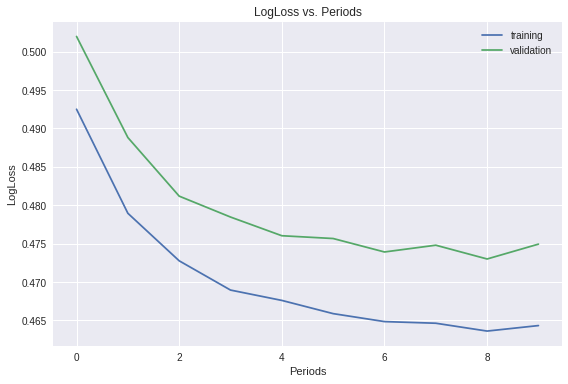

In [18]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000003,
    steps=20000,
    batch_size=500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])